## Fellowship.ai

# Global Terrorism 

Hi! I am Jeh Lokhande, a graduate student in analytics at Georgia Tech, with an interest in data science.

This notebook will take you through the process of data cleaning, feature creation and model building on the Global Terrorism database to predict the groups responsible using historical data. This is a multiclass classification problem with more than 3000 unique classes and hence poses a very different challenge when it comes to modelling. Approaches like boosting and  regression fail due to time complexity.  

Importing the required libraries

In [48]:
import pandas as pd
import numpy as np
import os
import calendar
import datetime
import missingno as msno
from pandas.tseries.holiday import USFederalHolidayCalendar


from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import scale

from sklearn.ensemble import RandomForestClassifier

from matplotlib import pyplot as plt
import seaborn as sns

Change directory and read the file

Note: The file that is being loaded has some work done on it, in Excel itself. 
1. The missing date values have been imputed from the 'approxdata' column

In [9]:
os.chdir('C:\\Users\\Jeh\\Desktop\\Fellowship')
gtd = pd.read_excel('globalterrorismdb_0617dist.xlsx')

**Exploratory Data Analysis**

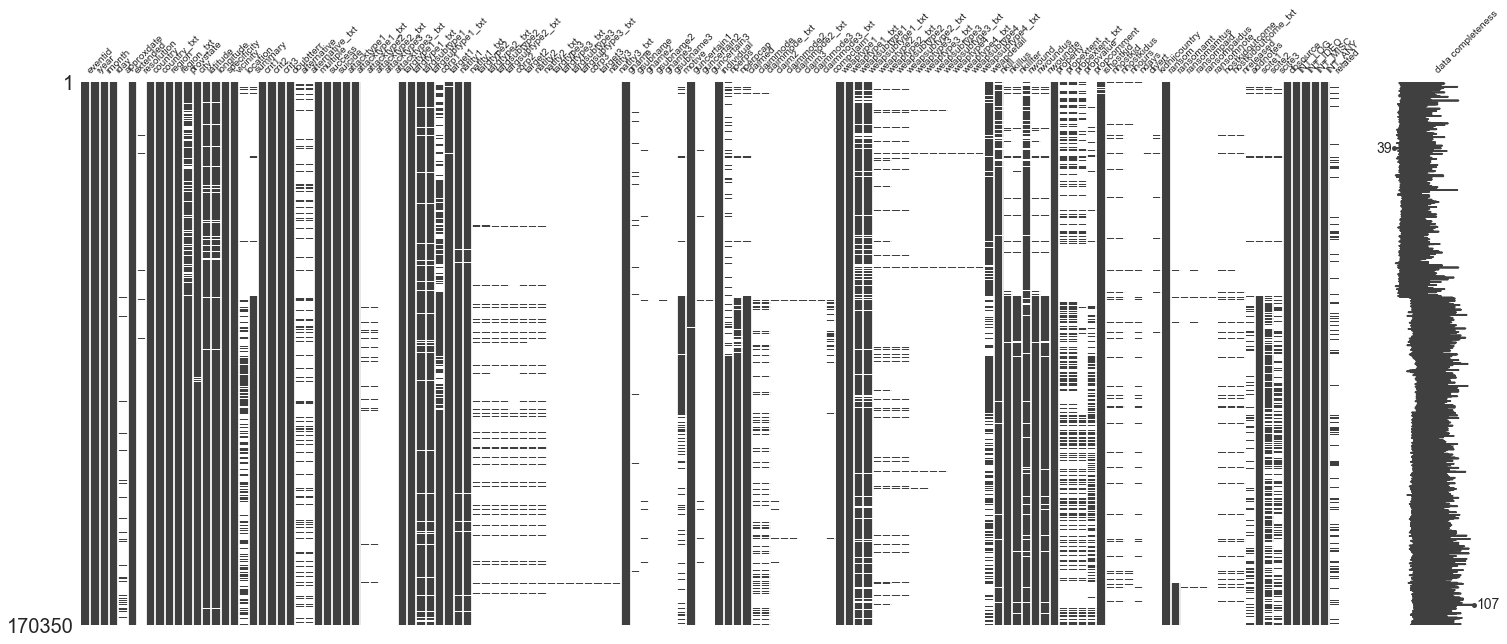

In [12]:
msno.matrix(gtd, labels=True, fontsize = 10)

The above chart can give you an idea of how sparse some columns are and hence it's very important to select attributes that have enough data to predict with good precision.

In [17]:
cols = []
for i in gtd.columns:
    if(gtd[i].notnull().all()):
        cols.append(i)

In [21]:
print("The columns that have no missing values are",cols)

The columns that have no missing values are ['eventid', 'iyear', 'imonth', 'iday', 'extended', 'country', 'country_txt', 'region', 'region_txt', 'vicinity', 'crit1', 'crit2', 'crit3', 'doubtterr', 'multiple', 'success', 'suicide', 'attacktype1', 'attacktype1_txt', 'targtype1', 'targtype1_txt', 'gname', 'individual', 'weaptype1', 'weaptype1_txt', 'property', 'ransom', 'dbsource', 'INT_LOG', 'INT_IDEO', 'INT_MISC', 'INT_ANY']


Some of the above columns are either just text representations of the their numerical values, such as 'country' and 'country_txt'.

Furthermore, columns citing the source aren't used in the prediction.

To get more information out of the date, I converted the date columns to a datetime format and extracted features from it such as day of the week, month, year and week-number.

In [47]:
#Count of countries in the dataset

gtdcountry = gtd.groupby('country_txt').count().iloc[:,1]
gtdcountry = gtdcountry.sort_values(ascending=False)

print('Top 10 countries with the highest number of terrorist attacks')
for i in range(10):
    print('Number of attacks for country ', gtdcountry.index[i], ' are:', gtdcountry[i])

Top 10 countries with the highest number of terrorist attacks
Number of attacks for country  Iraq  are: 22130
Number of attacks for country  Pakistan  are: 13634
Number of attacks for country  Afghanistan  are: 11306
Number of attacks for country  India  are: 10978
Number of attacks for country  Colombia  are: 8163
Number of attacks for country  Philippines  are: 6212
Number of attacks for country  Peru  are: 6088
Number of attacks for country  El Salvador  are: 5320
Number of attacks for country  United Kingdom  are: 5098
Number of attacks for country  Turkey  are: 4106


**Feature creation** (Date Time)

In [22]:
gtd['date'] = pd.to_datetime(gtd['iyear']*10000+gtd['imonth']*100+gtd['iday'],format='%Y%m%d')
gtd['weekday'] = gtd['date'].apply(lambda x: x.weekday())
gtd['year'] = gtd['date'].apply(lambda x: x.year)
gtd['month'] = gtd['date'].apply(lambda x: x.month)
gtd['weekno'] = gtd['date'].apply(lambda x: x.week)

##Weekday variables
gtd['is_day0']=0
gtd['is_day1']=0
gtd['is_day2']=0
gtd['is_day3']=0
gtd['is_day4']=0
gtd['is_day5']=0
gtd['is_day6']=0
gtd.loc[gtd['weekday']==0,'is_day0']=1 
gtd.loc[gtd['weekday']==1,'is_day1']=1 
gtd.loc[gtd['weekday']==2,'is_day2']=1 
gtd.loc[gtd['weekday']==3,'is_day3']=1 
gtd.loc[gtd['weekday']==4,'is_day4']=1 
gtd.loc[gtd['weekday']==5,'is_day5']=1 
gtd.loc[gtd['weekday']==6,'is_day6']=1 

Let us further look at the distribution of the data across months and days

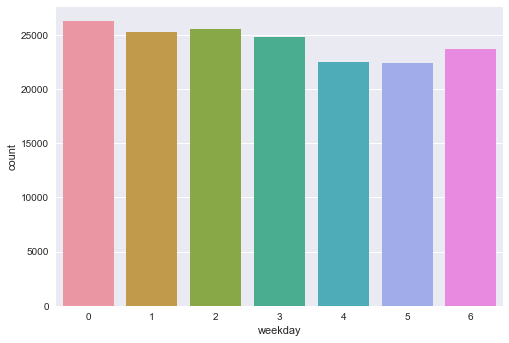

In [54]:
sns.countplot(x='weekday',data = gtd)
plt.show()

There is no specific pattern across days

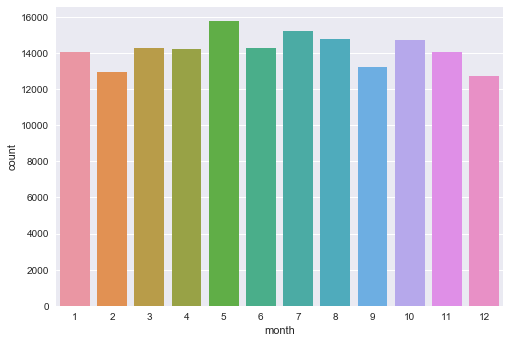

In [55]:
sns.countplot(x='month',data = gtd)
plt.show()

Again there isn't a major pattern in the data. The up's and down's can be attributed to the varying number of days in the months

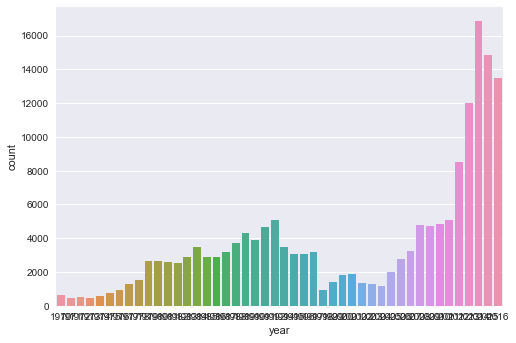

In [56]:
sns.countplot(x='year',data = gtd)
plt.show()

The number of crimes have increased over the years and has reached new heights around 2013.

I segregated the data to 2 groups;

First where the gname is known and this will be used to train and validate the model

Second where the gname is unknown, on which we will make the predictions

In [46]:
gtdtrain = gtd[gtd['gname']!='Unknown']
gtdtest = gtd[gtd['gname']=='Unknown']

print('Number of rows in gtdtrain =', len(gtdtrain)) 
print('Number of rows in gtdtest =', len(gtdtest)) 
print('Number of classes in the dataset = ', len(gtdtrain['gname'].unique()))

cols = ['year', 'month', 'weekday','weekno','country', 'region',
        'crit1', 'crit2', 'crit3', 'multiple', 'success',
        'suicide', 'attacktype1', 'targtype1', 'individual','weaptype1','property', 'ransom']

Number of rows in gtdtrain = 92044
Number of rows in gtdtest = 78306
Number of classes in the dataset =  3453


The features selected above do not have any missing data and hence are fed into the predictive model as predictors.

The problem in general is a unique one since the number of classes (in this classification problem) is more than 3000. Models that perform extremely well on binary or even multinomial (with <10 classes), fail to generate a good output or even stall due to this high number.

A logical thought would be that similar terrorrist groups would have a similar modus operandi, attack on similar days, have a similar appraoch towards taking hostages etc. and hence would lie close to each other in a k-dimensional space. I hence chose to train a *** K-Nearest-Neighbours *** model for this dataset.

Random Forest - accuracy - 25%

Gradient Boosting - terminated the training after 30 minutes

In [25]:
colsfinal = ['year', 'month', 'weekday','weekno','country', 'region',
        'crit1', 'crit2', 'crit3', 'multiple', 'success',
        'suicide', 'attacktype1', 'targtype1', 'individual','weaptype1','property', 'ransom']

gtdtrainx=gtdtrain.loc[:,colsfinal]
gtdtrainy = gtdtrain.loc[:,'gname']

One visual check to see if the data has any missing values or not.

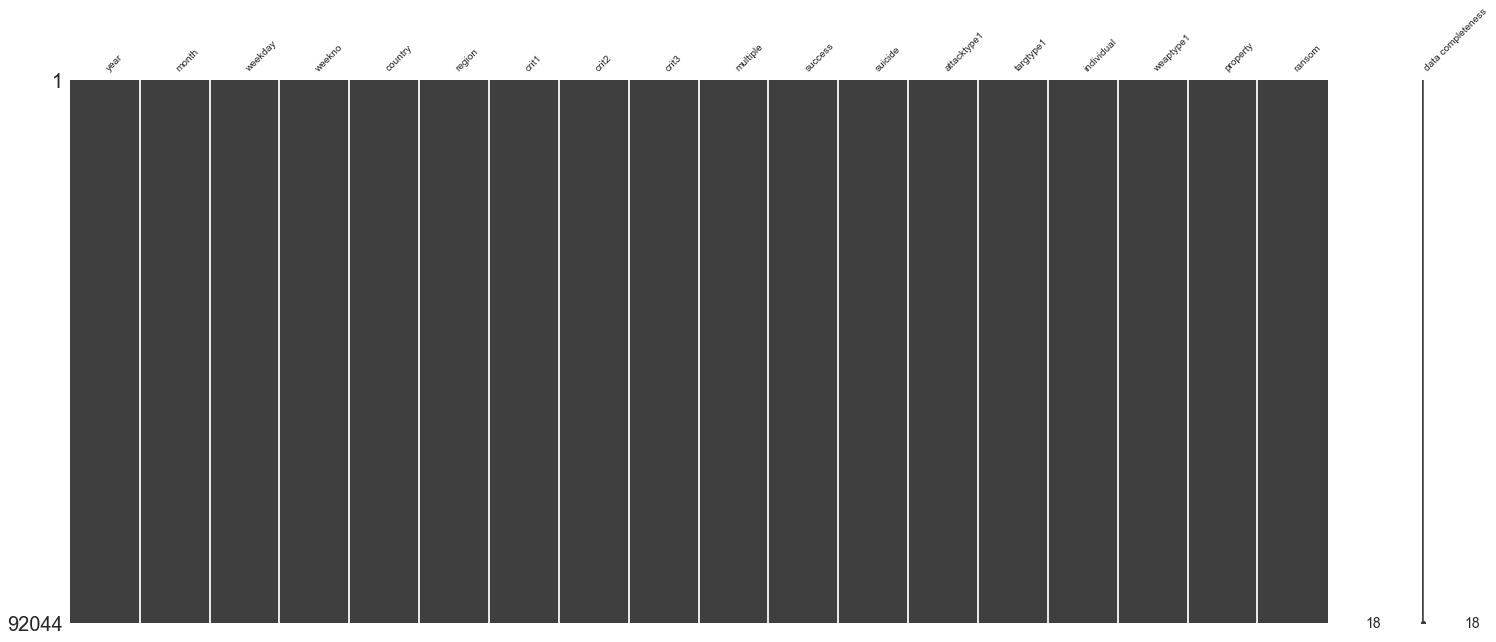

In [26]:
msno.matrix(gtdtrainx, labels=True, fontsize = 10)

We are good to go!

I then split up the gtdtrain dataset further into train and test.

Although it is better to scale your data in KNN, in this case I seemed to be getting a much higher accuracy without scaling it. 

In [27]:
#gtdtrainx = scale(gtdtrainx)
X_train, X_test, y_train, y_test = train_test_split(gtdtrainx, gtdtrainy, test_size=0.20)

Running the model to loop over the different values of 'k' to get the best one.

In [28]:
accuracy = pd.DataFrame(np.zeros((100,2)))
for i in range(1,100):
    knnmodel = KNeighborsClassifier(n_neighbors=i, weights='distance', algorithm='auto', leaf_size=30, p=1, metric='minkowski')
    knnmodel.fit(X_train, np.ravel(y_train))
    knn_test_output = knnmodel.predict(X_test)
    accuracy.iloc[i,0] = i 
    accuracy.iloc[i,1] = accuracy_score(knn_test_output,np.array(y_test))

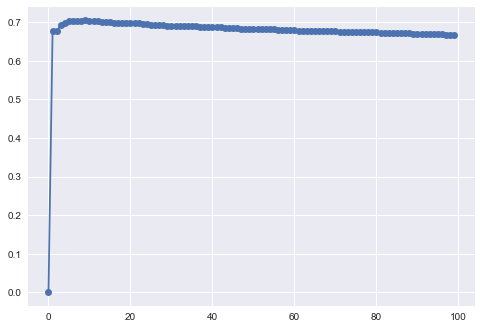

In [31]:
plt.plot( accuracy[0], accuracy[1] , linestyle='-', marker='o')
plt.show()

In [38]:
k_opt = accuracy[accuracy[1]==max(accuracy[1])][0]
print('The optimal k is: ', k_opt)

The optimal k is:  9    9.0
Name: 0, dtype: float64


In [39]:
knnmodel = KNeighborsClassifier(n_neighbors=9, weights='distance', algorithm='auto', leaf_size=30, p=1, metric='minkowski')
knnmodel.fit(X_train, np.ravel(y_train))
knn_test_output = knnmodel.predict(X_test)
accuracy_score(knn_test_output,np.array(y_test))

0.704981259166712

Now that the model is ready, I'll prep the test data for predictions

In [40]:
gtdtestx = gtdtest.loc[:,colsfinal]

In [41]:
knn_test_output = knnmodel.predict(gtdtestx)

**Comments**
I spent close to 4 hours on the project. There are few more ideas that I would have liked to try, mentioned below;
1. Identify religious holidays for each of the dates in the dataset. A lot of the terrorist groups associate themselves with a festival/date and that is something I want to capture
2. Extract text from the description, such as 'protest', 'kill' etc. This can further help identify organizations responsible for the crime. Organizations rarely deviate from their modus operandi
3. Time from the last attack can be added as a feature. 